# 기본 패키지 설치, 로드, 데이터 로드

In [1]:
!pip install pyspark
!apt install openjdk-8-jdk-headless -qq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 27 kB/s 
     |████████████████████████████████| 199 kB 37.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=7fbb3db742201ccb9b97af06c3176436beb215272440ab4c8063e51037a6735c
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upg

In [2]:
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark import SparkContext, SparkConf


sc=pyspark.SparkContext()
spark = SparkSession.builder.getOrCreate()


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

In [13]:
from google.colab import drive
drive.mount('/content/drive')

# Origin train, test data
train_data = spark.read.csv("/content/drive/MyDrive/빅데이터 처리 및 응용/팀플/train_data.csv", header=True, inferSchema=True)
test_data = spark.read.csv("/content/drive/MyDrive/빅데이터 처리 및 응용/팀플/test_data.csv", header=True, inferSchema=True)

# RandomOverSampling
oversample_train_data = spark.read.csv("/content/drive/MyDrive/빅데이터 처리 및 응용/팀플/oversample_train_data.csv", header=True, inferSchema=True)

# RandomUnderSampling
undersample_train_data = spark.read.csv("/content/drive/MyDrive/빅데이터 처리 및 응용/팀플/undersample_train_data.csv", header=True, inferSchema=True)

# Cost-Sensitive
cost_train_data = spark.read.csv("/content/drive/MyDrive/빅데이터 처리 및 응용/팀플/cost_train_data.csv", header=True, inferSchema=True)

# Smote
smote_train_data=spark.read.csv("/content/drive/MyDrive/빅데이터 처리 및 응용/팀플/smote_train_data.csv", header=True, inferSchema=True)

# Borderline Smote
borderline_smote_train_data=spark.read.csv("/content/drive/MyDrive/빅데이터 처리 및 응용/팀플/train_data_borderline.csv", header=True, inferSchema=True)
# ADASYN

adasyn_train_data =spark.read.csv("/content/drive/MyDrive/빅데이터 처리 및 응용/팀플/adasyn_train_data.csv", header=True, inferSchema=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 모델에 넣기 위한 데이터 벡터화 생성 함수

In [14]:
from pyspark.ml.feature import VectorAssembler

def Make_Model_Form(train_data, test_data, feature, label, weight=None):

  assembler = VectorAssembler(inputCols=feature, outputCol='Features')

  output=assembler.transform(train_data)

  if weight==None:
    final_train=output.select("Features", label)
  else:
    final_train=output.select("Features", "weight", label)

  output=assembler.transform(test_data)
  final_test=output.select("Features", label)
  return final_train, final_test

# 각 모델 생성 함수

In [15]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier


# 로지스틱 모델 생성
def Logistic(final_train, final_test, label, weight=None):

  if weight==None:
    classifier=LogisticRegression(featuresCol='Features', labelCol=label)
  # Cost Learn  
  else:
    classifier=LogisticRegression(featuresCol='Features', labelCol=label, weightCol=weight)

  #train_data set학습
  model=classifier.fit(final_train)

  #test_data set 예측
  pred=model.transform(final_test)

  return pred

def DT(final_train, final_test, label, weight=None):

  if weight==None:
    classifier=DecisionTreeClassifier(featuresCol='Features', labelCol=label)
  # Cost Learn  
  else:
    classifier=DecisionTreeClassifier(featuresCol='Features', labelCol=label, weightCol=weight)

  #train_data set학습
  model=classifier.fit(final_train)

  #test_data set 예측
  pred=model.transform(final_test)

  return pred

def RF(final_train, final_test, label, weight=None):

  if weight==None:
    classifier=RandomForestClassifier(featuresCol='Features', labelCol=label)
  # Cost Learn  
  else:
    classifier=RandomForestClassifier(featuresCol='Features', labelCol=label, weightCol=weight)

  #train_data set학습
  model=classifier.fit(final_train)

  #test_data set 예측
  pred=model.transform(final_test)

  return pred

def GBT(final_train, final_test, label, weight=None):

  if weight==None:
    classifier=GBTClassifier(featuresCol='Features', labelCol=label)
  # Cost Learn  
  else:
    classifier=GBTClassifier(featuresCol='Features', labelCol=label, weightCol=weight)

  #train_data set학습
  model=classifier.fit(final_train)

  #test_data set 예측
  pred=model.transform(final_test)

  return pred



# 성능 평가 함수


In [6]:
from sklearn import metrics

# 평가 함수
def Confusion_Matrix(pred):
  result=pred.toPandas()
  y_test=result['HeartDisease_Index']
  y_pred=result['prediction']

  acc = metrics.accuracy_score(y_test, y_pred)
  prec = metrics.precision_score(y_test, y_pred)
  rec = metrics.recall_score(y_test, y_pred)
  f1 = metrics.f1_score(y_test, y_pred)

  # Display confusion matrix
  cm = metrics.confusion_matrix(y_test, y_pred)

  print(f"Accuracy {acc}")
  print(f"Precision {prec}")
  print(f"Recall {rec}")
  print(f"F1 {f1}")

  print(cm)

  plt.subplot(1,2,2)
  plt.title('Confusion Matrix')
  sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
  plt.xlabel('predict label')
  plt.ylabel('true label')
  plt.show()

# feature 이용 컬럼과, label 분리

In [7]:
use_variable=train_data.columns[1:]
label=train_data.columns[0]

use_variable

['Smoking_Index',
 'AlcoholDrinking_Index',
 'Stroke_Index',
 'DiffWalking_Index',
 'Sex_Index',
 'PhysicalActivity_Index',
 'Asthma_Index',
 'KidneyDisease_Index',
 'SkinCancer_Index',
 'AgeCategory_Index',
 'GenHealth_Index',
 'Diabetic_Index',
 'BMI_Log',
 'PhysicalHealth_Log',
 'MentalHealth_Log',
 'SleepTime_Log']

In [ ]:
label

'HeartDisease_Index'

# 원본 데이터(불균형 상태)를 이용한 모델

#### 원본+로지스틱

Accuracy 0.9108853458848487
Precision 0.5343915343915344
Recall 0.11109074243813015
F1 0.183942935195022
[[54355   528]
 [ 4849   606]]


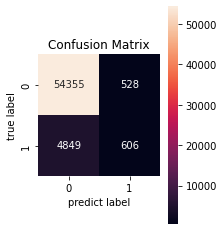

In [ ]:
final_train, final_test=Make_Model_Form(train_data, test_data, use_variable, label)
origin_Logistic_pred=Logistic(final_train, final_test, label)
Confusion_Matrix(origin_Logistic_pred)

#### 원본+DecisionTree

Accuracy 0.9103052802545659
Precision 0.5380530973451327
Recall 0.055728689275893674
F1 0.10099667774086378
[[54622   261]
 [ 5151   304]]


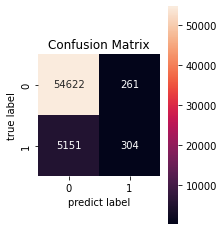

In [ ]:
origin_DT_pred=DT(final_train, final_test, label)
Confusion_Matrix(origin_DT_pred)

#### 원본+RandomForest

Accuracy 0.9100732540024529
Precision 0.7543859649122807
Recall 0.007882676443629697
F1 0.015602322206095792
[[54869    14]
 [ 5412    43]]


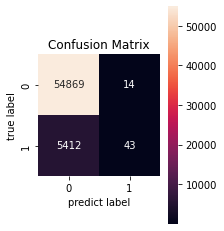

In [ ]:
origin_RF_pred=RF(final_train, final_test, label)
Confusion_Matrix(origin_RF_pred)

#### 원본+GBT

Accuracy 0.9111505187444066
Precision 0.5633423180592992
Recall 0.0766269477543538
F1 0.13490398579958043
[[54559   324]
 [ 5037   418]]


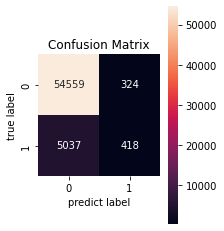

In [ ]:
origin_GBT_pred=GBT(final_train, final_test, label)
Confusion_Matrix(origin_GBT_pred)

# RandomOverSampling를 이용한 모델

#### RandomOverSampling+로지스틱

Accuracy 0.74376015114853
Precision 0.22947983129663674
Recall 0.7780018331805683
F1 0.35441980876028223
[[40633 14250]
 [ 1211  4244]]


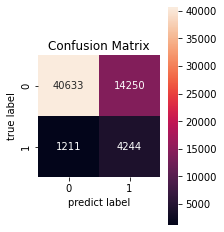

In [ ]:
oversample_final_train, oversample_final_test=Make_Model_Form(oversample_train_data, test_data, use_variable, label)
oversample_Logistic_pred=Logistic(oversample_final_train, oversample_final_test, label)
Confusion_Matrix(oversample_Logistic_pred)

#### RandomOverSampling+DecisionTree

Accuracy 0.710298650933077
Precision 0.20868259121081448
Recall 0.7895508707607699
F1 0.3301142024986587
[[38551 16332]
 [ 1148  4307]]


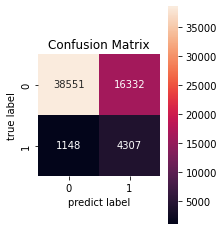

In [ ]:
oversample_DT_pred=DT(oversample_final_train, oversample_final_test, label)
Confusion_Matrix(oversample_DT_pred)

#### RandomOverSampling+RF

Accuracy 0.7116079419271437
Precision 0.2077502691065662
Recall 0.7783684692942254
F1 0.32796508708917466
[[38691 16192]
 [ 1209  4246]]


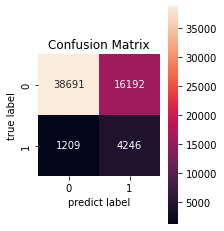

In [ ]:
oversample_RF_pred=RF(oversample_final_train, oversample_final_test, label)
Confusion_Matrix(oversample_RF_pred)

####RandomOverSampling+GBT

Accuracy 0.7236567337333024
Precision 0.21872336158050443
Recall 0.7996333638863428
F1 0.343491613512875
[[39302 15581]
 [ 1093  4362]]


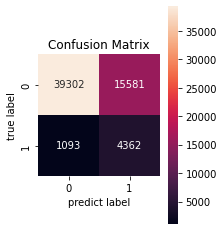

In [ ]:
oversample_GBT_pred=GBT(oversample_final_train, oversample_final_test, label)
Confusion_Matrix(oversample_GBT_pred)

# RandomUnderSampling 이용한 모델

#### RandomUnderSampling+로지스틱

Accuracy 0.7450031489277072
Precision 0.23012120223925214
Recall 0.7761686526122823
F1 0.35499287331265195
[[40718 14165]
 [ 1221  4234]]


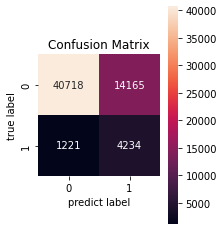

In [ ]:
undersample_final_train, undersample_final_test=Make_Model_Form(undersample_train_data, test_data, use_variable, label)
undersample_Logistic_pred=Logistic(undersample_final_train, undersample_final_test, label)
Confusion_Matrix(undersample_Logistic_pred)

#### RandomUnderSampling+DecisionTree

Accuracy 0.7238556133779708
Precision 0.21441312879058153
Recall 0.7712190650779102
F1 0.3355399585260807
[[39469 15414]
 [ 1248  4207]]


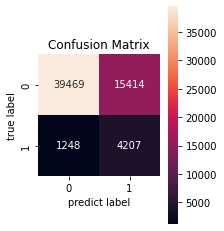

In [ ]:
undersample_DT_pred=DT(undersample_final_train, undersample_final_test, label)
Confusion_Matrix(undersample_DT_pred)

#### RandomUnderSampling+RF

Accuracy 0.7115250754085319
Precision 0.20772805086818294
Recall 0.7785517873510541
F1 0.327953667953668
[[38685 16198]
 [ 1208  4247]]


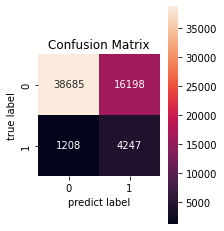

In [ ]:
undersample_RF_pred=RF(undersample_final_train, undersample_final_test, label)
Confusion_Matrix(undersample_RF_pred)

#### RandomUnderSampling+GBT

Accuracy 0.7258941297358216
Precision 0.2189085007100832
Recall 0.7912007332722273
F1 0.34293432918835165
[[39483 15400]
 [ 1139  4316]]


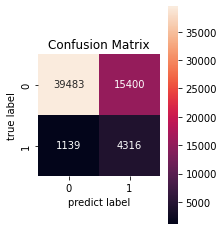

In [ ]:
undersample_GBT_pred=GBT(undersample_final_train, undersample_final_test, label)
Confusion_Matrix(undersample_GBT_pred)

# CostSensitive Model

#### CostSensitive+Logistic

Accuracy 0.7417382080944015
Precision 0.2284136007722836
Recall 0.7807516040329973
F1 0.3534293182855483
[[40496 14387]
 [ 1196  4259]]


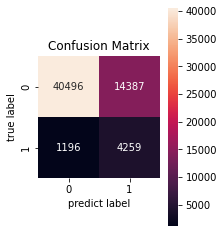

In [ ]:
cost_final_train, cost_final_test=Make_Model_Form(cost_train_data, test_data, use_variable, label, weight="weight")
cost_Logistic_pred=Logistic(cost_final_train, cost_final_test, label, weight="weight")
Confusion_Matrix(cost_Logistic_pred)

#### Cost+DecisionTree

Accuracy 0.710298650933077
Precision 0.20868259121081448
Recall 0.7895508707607699
F1 0.3301142024986587
[[38551 16332]
 [ 1148  4307]]


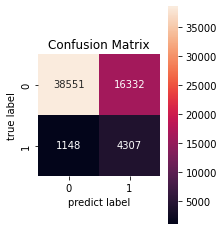

In [ ]:
cost_DT_pred=DT(cost_final_train, cost_final_test, label,  weight="weight")
Confusion_Matrix(cost_DT_pred)

#### Cost+RF

Accuracy 0.709934038251185
Precision 0.20755449822789726
Recall 0.7836846929422548
F1 0.3281897742975587
[[38561 16322]
 [ 1180  4275]]


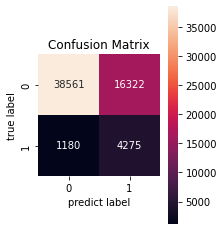

In [ ]:
cost_RF_pred=RF(cost_final_train, cost_final_test, label,  weight="weight")
Confusion_Matrix(cost_RF_pred)

#### Cost+GBT

Accuracy 0.7222314296131791
Precision 0.218065738939598
Recall 0.8014665444546287
F1 0.3428481806775408
[[39206 15677]
 [ 1083  4372]]


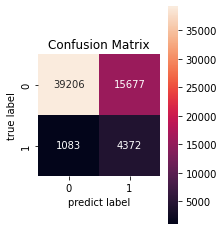

In [ ]:
cost_GBT_pred=GBT(cost_final_train, cost_final_test, label,  weight="weight")
Confusion_Matrix(cost_GBT_pred)

# SMOTE를 이용한 모델

#### SMOTE+로지스틱

Accuracy 0.6993602704763168
Precision 0.13280842934058937
Recall 0.42053162236480296
F1 0.2018655403027103
[[39904 14979]
 [ 3161  2294]]


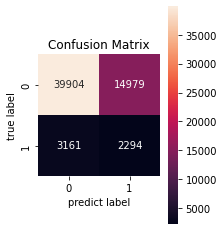

In [ ]:
smote_final_train, smote_final_test=Make_Model_Form(smote_train_data, test_data, use_variable, label)
smote_Logistic_pred=Logistic(smote_final_train, smote_final_test, label)
Confusion_Matrix(smote_Logistic_pred)

#### SMOTE+DecisionTree

Accuracy 0.8474261659319169
Precision 0.07384685298795728
Recall 0.05957836846929423
F1 0.06594967532467533
[[50807  4076]
 [ 5130   325]]


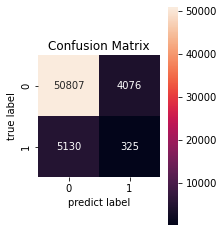

In [ ]:
smote_DT_pred=DT(smote_final_train, smote_final_test, label)
Confusion_Matrix(smote_DT_pred)

####SMOTE+RF

Accuracy 0.8738274387616427
Precision 0.055234954657873044
Recall 0.02456461961503208
F1 0.03400583682273823
[[52591  2292]
 [ 5321   134]]


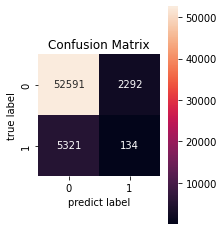

In [ ]:
smote_RF_pred=RF(smote_final_train, smote_final_test, label)
Confusion_Matrix(smote_RF_pred)

#### SMOTE_GBT

Accuracy 0.8893400510457755
Precision 0.17221030042918456
Recall 0.05884509624197984
F1 0.08771690121601312
[[53340  1543]
 [ 5134   321]]


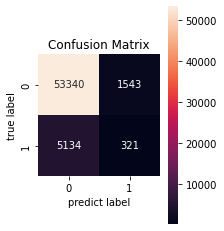

In [ ]:
smote_GBT_pred=GBT(smote_final_train, smote_final_test, label)
Confusion_Matrix(smote_GBT_pred)

#### 반올림 SMOTE+로지스틱

Borderline + 로지스틱

Accuracy 0.7531074944479432
Precision 0.15055514433752776
Recall 0.37286892758936757
F1 0.2145003954653309
[[43407 11476]
 [ 3421  2034]]


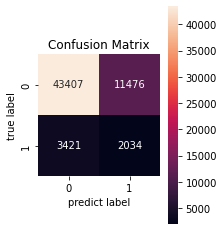

In [8]:
borderline_smote_train, borderline_smote_test=Make_Model_Form(borderline_smote_train_data, test_data, use_variable, label)
smote_Logistic_pred=Logistic(borderline_smote_train, borderline_smote_test, label)
Confusion_Matrix(smote_Logistic_pred)

Borderline + Decision Tree

Accuracy 0.8619940999038749
Precision 0.08994860079954312
Recall 0.05774518790100825
F1 0.07033605001674667
[[51696  3187]
 [ 5140   315]]


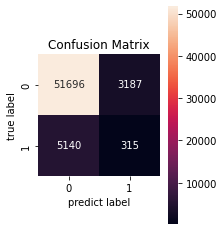

In [10]:
borderline_DT_pred=DT(borderline_smote_train, borderline_smote_test, label)
Confusion_Matrix(borderline_DT_pred)

Borderline + RF

Accuracy 0.8551990453777056
Precision 0.05744336569579288
Recall 0.03904674610449129
F1 0.04649132380224817
[[51388  3495]
 [ 5242   213]]


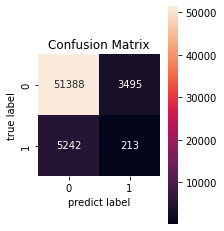

In [11]:
borderline_RF_pred=RF(borderline_smote_train, borderline_smote_test, label)
Confusion_Matrix(borderline_RF_pred)

Borderline + GBT

Accuracy 0.8925552719679141
Precision 0.1862026862026862
Recall 0.05591200733272227
F1 0.0860002819681376
[[53550  1333]
 [ 5150   305]]


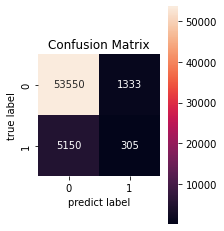

In [12]:
borderline_GBT_pred=GBT(borderline_smote_train, borderline_smote_test, label)
Confusion_Matrix(borderline_GBT_pred)

adasyn + 로지스틱

Accuracy 0.7879942987835195
Precision 0.1677384294900824
Recall 0.3395050412465628
F1 0.22453928225024244
[[45694  9189]
 [ 3603  1852]]


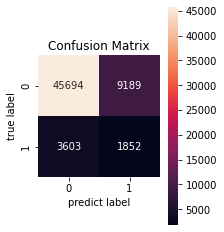

In [16]:
adasyn_train, adasyn_test=Make_Model_Form(adasyn_train_data, test_data, use_variable, label)
adasyn_Logistic_pred=Logistic(adasyn_train, adasyn_test, label)
Confusion_Matrix(adasyn_Logistic_pred)

adasyn + decision tree

Accuracy 0.8500281746163281
Precision 0.087465564738292
Recall 0.06984417965169569
F1 0.07766792375904596
[[50908  3975]
 [ 5074   381]]


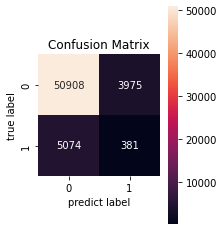

In [19]:
adasyn_DT_pred=DT(adasyn_train, adasyn_test, label)
Confusion_Matrix(adasyn_DT_pred)

adasyn + RF

Accuracy 0.8689714607709901
Precision 0.0593311758360302
Recall 0.03024747937671861
F1 0.04006799417192813
[[52267  2616]
 [ 5290   165]]


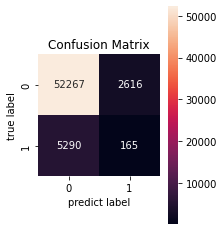

In [20]:
adasyn_RF_pred=RF(adasyn_train, adasyn_test, label)
Confusion_Matrix(adasyn_RF_pred)

adasyn + GBT

Accuracy 0.9010242301700421
Precision 0.27849185946872324
Recall 0.05957836846929423
F1 0.0981576562971912
[[54041   842]
 [ 5130   325]]


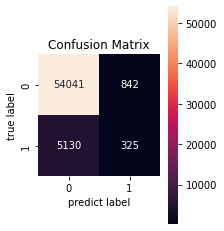

In [21]:
adasyn_GBT_pred=GBT(adasyn_train, adasyn_test, label)
Confusion_Matrix(adasyn_GBT_pred)